##### This script sets up and demonstrates some of the pre-processing steps needed to feed data into a GLM



In [17]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import sqlite3
from sqlite3 import Error
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn import svm, metrics
#from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import math

In [2]:
file_chartevents = 'CHARTEVENTS.csv'
CHARTEVENTS = pd.read_csv(file_chartevents, nrows = 10)
#patientsIDsFN = input('Please input the file name containing the subject IDs of interest.')

In [3]:
print(CHARTEVENTS)

   ROW_ID  SUBJECT_ID  HADM_ID  ICUSTAY_ID  ITEMID            CHARTTIME  \
0     788          36   165660      241249  223834  2134-05-12 12:00:00   
1     789          36   165660      241249  223835  2134-05-12 12:00:00   
2     790          36   165660      241249  224328  2134-05-12 12:00:00   
3     791          36   165660      241249  224329  2134-05-12 12:00:00   
4     792          36   165660      241249  224330  2134-05-12 12:00:00   
5     793          36   165660      241249  224331  2134-05-12 12:00:00   
6     794          36   165660      241249  224332  2134-05-12 12:00:00   
7     795          36   165660      241249  224663  2134-05-12 12:00:00   
8     796          36   165660      241249  224665  2134-05-12 12:00:00   
9     797          36   165660      241249  220224  2134-05-12 12:35:00   

             STORETIME   CGID   VALUE  VALUENUM VALUEUOM  WARNING  ERROR  \
0  2134-05-12 13:56:00  17525   15.00     15.00    L/min        0      0   
1  2134-05-12 13:56:00

In [4]:
#CHARTEVENTS_database = create_engine('sqlite:///chartevents_database.db')
#chunksize = 100000
#i = 0
#j = 1
#for df in pd.read_csv(file_chartevents, chunksize=chunksize, iterator=True):
#      df = df.rename(columns={c: c.replace(' ', '') for c in df.columns}) 
#      df.index += j
#      i+=1
#      df.to_sql('table', CHARTEVENTS_database, if_exists='append')
#      j = df.index[-1] + 1

In [5]:
#PATIENTS_database = create_engine('sqlite:///patients_database.db')
#file = 'PATIENTS.csv'
#chunksize = 100000
#i = 0
#j = 1
#for df in pd.read_csv(file, chunksize=chunksize, iterator=True):
#      df = df.rename(columns={c: c.replace(' ', '') for c in df.columns}) 
#      df.index += j
#      i+=1
#      df.to_sql('table', PATIENTS_database, if_exists='append')
#      j = df.index[-1] + 1

In [6]:
#ADMISSIONS_database = create_engine('sqlite:///admissions_database.db')
#file = 'ADMISSIONS.csv'
#chunksize = 100000
#i = 0
#j = 1
#for df in pd.read_csv(file, chunksize=chunksize, iterator=True):
#      df = df.rename(columns={c: c.replace(' ', '') for c in df.columns}) 
#      df.index += j
#      i+=1
#      df.to_sql('table', ADMISSIONS_database, if_exists='append')
#      j = df.index[-1] + 1

##### Probably the best place to go from here is to create functions to return a 2d array of time stamps and values associated with physiological measurements. From there can do things like feed 

##### aggregate stats: min, max, stdev, variance, kurtosis

###### grab all lab events and look for prevalence 

###### for naive GLM, build 1 row for each patient with demographic data: currently have ethnicity, marital status, admission type, admission location

In [7]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by the db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)

    return conn


In [8]:
patients_conn = create_connection('patients_database.db')
admissions_conn = create_connection('admissions_database.db')

cur = patients_conn.cursor()
#cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
#print(cur.fetchall())


    

In [9]:
#cur.execute("SELECT * FROM table")

#rows = cur.fetchall()

#cur.close()

#for row in rows:
 #   print(row)

In [46]:
PATIENTS = pd.read_csv('E:\\mimic-iii-clinical-database-1.4\\mimic-unzipped\\PATIENTS.csv', 
                       usecols=['SUBJECT_ID', 'GENDER'])

#patient_ids = PATIENTS['SUBJECT_ID']
#No duplicates
#unique_patient_ids = set()
PATIENTS.drop_duplicates(inplace=True)

PATIENTS.shape[0]



46520

'E:\\mimic-iii-clinical-database-1.4\\mimic-unzipped'

In [11]:
ADMISSIONS = pd.read_csv('admissions.csv')

In [50]:
#Build one hot encoding of ethnicities
ethnicities = pd.read_csv('E:\\mimic-iii-clinical-database-1.4\\mimic-unzipped\\admissions.csv',
                          usecols=['SUBJECT_ID','ETHNICITY'])

ethnicities['ETHNICITY'].value_counts()

#build dataframe with all subject ids and the one hot encoding of their ethnicities
ethnicities = pd.get_dummies(ethnicities, columns=['ETHNICITY'])
ethnicities['SUBJECT_ID'].isin(PATIENTS)

#ethnicities = ethnicities[ethnicities['SUBJECT_ID'].isin([25,27])]

ethnicities
#ethnicities['SUBJECT_ID']

#look up dataframe.merge to do joins

#ethnicity_dict = {}

#unique_ethnicities = set()

#for index, value in ADMISSIONS['ETHNICITY'].items():
#    unique_ethnicities.add(value)

#val = 0
#for key in unique_ethnicities:
#    ethnicity_dict[key] = val
#    val = val+1

# print(ethnicity_dict)

,SUBJECT_ID,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ETHNICITY_ASIAN,ETHNICITY_ASIAN - ASIAN INDIAN,ETHNICITY_ASIAN - CAMBODIAN,ETHNICITY_ASIAN - CHINESE,ETHNICITY_ASIAN - FILIPINO,ETHNICITY_ASIAN - JAPANESE,ETHNICITY_ASIAN - KOREAN,...,ETHNICITY_PATIENT DECLINED TO ANSWER,ETHNICITY_PORTUGUESE,ETHNICITY_SOUTH AMERICAN,ETHNICITY_UNABLE TO OBTAIN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_WHITE,ETHNICITY_WHITE - BRAZILIAN,ETHNICITY_WHITE - EASTERN EUROPEAN,ETHNICITY_WHITE - OTHER EUROPEAN,ETHNICITY_WHITE - RUSSIAN
0,22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,98800,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
58972,98802,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
58973,98805,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
58974,98813,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [40]:
maritalStatus_dict = {}

unique_maritalStatus = set()

for index, value in ADMISSIONS['MARITAL_STATUS'].items():
    unique_maritalStatus.add(value)

val = 0
for key in unique_maritalStatus:
    maritalStatus_dict[key] = val
    val = val+1
    
print(maritalStatus_dict)

NameError: name 'ADMISSIONS' is not defined

In [14]:
admissionType_dict = {}

unique_admissionTypes = set()

for index, value in ADMISSIONS['ADMISSION_TYPE'].items():
    unique_admissionTypes.add(value)

val = 0
for key in unique_admissionTypes:
    admissionType_dict[key] = val
    val = val+1
    
print(admissionType_dict)

{'URGENT': 0, 'EMERGENCY': 1, 'ELECTIVE': 2, 'NEWBORN': 3}


In [15]:
admissionLocation_dict = {}

unique_admissionLocations = set()

for index, value in ADMISSIONS['ADMISSION_LOCATION'].items():
    unique_admissionLocations.add(value)

val = 0
for key in unique_admissionLocations:
    admissionLocation_dict[key] = val
    val = val+1
    
for key, value in admissionLocation_dict.items():
    print(key, ' : ', value)

TRANSFER FROM OTHER HEALT  :  0
EMERGENCY ROOM ADMIT  :  1
PHYS REFERRAL/NORMAL DELI  :  2
TRANSFER FROM HOSP/EXTRAM  :  3
TRSF WITHIN THIS FACILITY  :  4
CLINIC REFERRAL/PREMATURE  :  5
** INFO NOT AVAILABLE **  :  6
TRANSFER FROM SKILLED NUR  :  7
HMO REFERRAL/SICK  :  8


In [17]:
featureNames = ['ethnicity', 'Marital Status', 'Admission Type', 'Admission Location']


features = []
features.append(ethnicity_dict)
features.append(maritalStatus_dict)
features.append(admissionType_dict)
features.append(admissionLocation_dict)

features

[{'HISPANIC/LATINO - MEXICAN': 0,
  'HISPANIC/LATINO - SALVADORAN': 1,
  'BLACK/HAITIAN': 2,
  'MULTI RACE ETHNICITY': 3,
  'HISPANIC/LATINO - GUATEMALAN': 4,
  'WHITE - OTHER EUROPEAN': 5,
  'ASIAN - JAPANESE': 6,
  'WHITE - EASTERN EUROPEAN': 7,
  'OTHER': 8,
  'UNKNOWN/NOT SPECIFIED': 9,
  'HISPANIC/LATINO - COLOMBIAN': 10,
  'ASIAN - KOREAN': 11,
  'PATIENT DECLINED TO ANSWER': 12,
  'CARIBBEAN ISLAND': 13,
  'BLACK/AFRICAN': 14,
  'WHITE - BRAZILIAN': 15,
  'PORTUGUESE': 16,
  'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 17,
  'BLACK/CAPE VERDEAN': 18,
  'ASIAN - VIETNAMESE': 19,
  'HISPANIC/LATINO - HONDURAN': 20,
  'ASIAN - THAI': 21,
  'ASIAN - OTHER': 22,
  'ASIAN - CHINESE': 23,
  'WHITE - RUSSIAN': 24,
  'ASIAN - FILIPINO': 25,
  'MIDDLE EASTERN': 26,
  'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE': 27,
  'ASIAN - ASIAN INDIAN': 28,
  'UNABLE TO OBTAIN': 29,
  'HISPANIC/LATINO - CUBAN': 30,
  'HISPANIC/LATINO - DOMINICAN': 31,
  'ASIAN': 32,
  'HISPANIC/LATINO -

# Convert dictionary values to one hot encoding

In [18]:
def toOneHot(integer_encoded):
    #categorical input should be 0..N-1 with no gaps
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

In [19]:
ethnicity_oneHot = toOneHot(np.array(list(ethnicity_dict.values())))
for key,value in ethnicity_dict.items():
    ethnicity_dict[key] = ethnicity_oneHot[value]

print(ethnicity_dict)

{'HISPANIC/LATINO - MEXICAN': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.]), 'HISPANIC/LATINO - SALVADORAN': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.]), 'BLACK/HAITIAN': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.]), 'MULTI RACE ETHNICITY': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.]), 'HISPANIC/LATINO - GUATEMALAN': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [20]:
maritalStatus_oneHot = toOneHot(np.array(list(maritalStatus_dict.values())))
for key,value in maritalStatus_dict.items():
    maritalStatus_dict[key] = maritalStatus_oneHot[value]

print(maritalStatus_dict)

{nan: array([1., 0., 0., 0., 0., 0., 0., 0.]), 'LIFE PARTNER': array([0., 1., 0., 0., 0., 0., 0., 0.]), 'WIDOWED': array([0., 0., 1., 0., 0., 0., 0., 0.]), 'MARRIED': array([0., 0., 0., 1., 0., 0., 0., 0.]), 'UNKNOWN (DEFAULT)': array([0., 0., 0., 0., 1., 0., 0., 0.]), 'SEPARATED': array([0., 0., 0., 0., 0., 1., 0., 0.]), 'SINGLE': array([0., 0., 0., 0., 0., 0., 1., 0.]), 'DIVORCED': array([0., 0., 0., 0., 0., 0., 0., 1.])}


In [21]:
admissionType_oneHot = toOneHot(np.array(list(admissionType_dict.values())))
for key,value in admissionType_dict.items():
    admissionType_dict[key] = admissionType_oneHot[value]

print(admissionType_dict)

{'URGENT': array([1., 0., 0., 0.]), 'EMERGENCY': array([0., 1., 0., 0.]), 'ELECTIVE': array([0., 0., 1., 0.]), 'NEWBORN': array([0., 0., 0., 1.])}


In [22]:
admissionLocation_oneHot = toOneHot(np.array(list(admissionLocation_dict.values())))
for key,value in admissionLocation_dict.items():
    admissionLocation_dict[key] = admissionLocation_oneHot[value]

print(admissionLocation_dict)

{'TRANSFER FROM OTHER HEALT': array([1., 0., 0., 0., 0., 0., 0., 0., 0.]), 'EMERGENCY ROOM ADMIT': array([0., 1., 0., 0., 0., 0., 0., 0., 0.]), 'PHYS REFERRAL/NORMAL DELI': array([0., 0., 1., 0., 0., 0., 0., 0., 0.]), 'TRANSFER FROM HOSP/EXTRAM': array([0., 0., 0., 1., 0., 0., 0., 0., 0.]), 'TRSF WITHIN THIS FACILITY': array([0., 0., 0., 0., 1., 0., 0., 0., 0.]), 'CLINIC REFERRAL/PREMATURE': array([0., 0., 0., 0., 0., 1., 0., 0., 0.]), '** INFO NOT AVAILABLE **': array([0., 0., 0., 0., 0., 0., 1., 0., 0.]), 'TRANSFER FROM SKILLED NUR': array([0., 0., 0., 0., 0., 0., 0., 1., 0.]), 'HMO REFERRAL/SICK': array([0., 0., 0., 0., 0., 0., 0., 0., 1.])}


In [31]:
X = pd.DataFrame([[-1,-1,-1]])
Y = pd.DataFrame([[0]])
#count = 0
for i in unique_patient_ids:
    curRow = PATIENTS[PATIENTS['SUBJECT_ID'] == i]
    curGender = curRow['GENDER'].iloc[0]
    if(curGender == 'M'):
        curGender = 0
    else:
        curGender = 1 #i.e. Female 1 Male 0
    
    curRow = ADMISSIONS[ADMISSIONS['SUBJECT_ID'] == i]
    curEthnicity = list(ethnicity_dict[curRow['ETHNICITY'].iloc[0]])
    curMarriageStatus = list(maritalStatus_dict[curRow['MARITAL_STATUS'].iloc[0]])
    curAdmissionType = list(admissionType_dict[curRow['ADMISSION_TYPE'].iloc[0]])
    curAdmissionLocation = list(admissionLocation_dict[curRow['ADMISSION_LOCATION'].iloc[0]])
    curDeathStatus = curRow['HOSPITAL_EXPIRE_FLAG'].iloc[0]
    
    
    #update curValues to integers based on pre-processed dictionaries
    Xrow_i = []
    for val in curEthnicity:
        Xrow_i.append(val)
        
    for val in curMarriageStatus:
        Xrow_i.append(val)
        
    for val in curAdmissionType:
        Xrow_i.append(val)
        
    for val in curAdmissionLocation:
        Xrow_i.append(val)

    Xrow_i = pd.Series(Xrow_i)
    
    
    Xrow_i_df = pd.DataFrame([Xrow_i])
    
    Yrow_i = pd.Series([curDeathStatus])
    Yrow_i_df = pd.DataFrame([Yrow_i])
    
    X = pd.concat([X, Xrow_i_df], ignore_index=True)
    Y = pd.concat([Y, Yrow_i_df], ignore_index=True)
    #count = count + 1


In [53]:
test = ethnicities.merge(PATIENTS, how='right', on=['SUBJECT_ID'])
test

,SUBJECT_ID,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ETHNICITY_ASIAN,ETHNICITY_ASIAN - ASIAN INDIAN,ETHNICITY_ASIAN - CAMBODIAN,ETHNICITY_ASIAN - CHINESE,ETHNICITY_ASIAN - FILIPINO,ETHNICITY_ASIAN - JAPANESE,ETHNICITY_ASIAN - KOREAN,...,ETHNICITY_PORTUGUESE,ETHNICITY_SOUTH AMERICAN,ETHNICITY_UNABLE TO OBTAIN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_WHITE,ETHNICITY_WHITE - BRAZILIAN,ETHNICITY_WHITE - EASTERN EUROPEAN,ETHNICITY_WHITE - OTHER EUROPEAN,ETHNICITY_WHITE - RUSSIAN,GENDER
0,249,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,F
1,249,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,F
2,249,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,F
3,250,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,F
4,251,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,44089,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,M
58972,44115,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,F
58973,44123,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,F
58974,44126,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,F


In [32]:
X = X[1:] #first row is invalid by construction so leave it out

In [33]:
Y = Y[1:] #first row is invalid by construction so leave it out

In [34]:
y_train = Y[:int(46520/2)].values.ravel()
y_test = Y[int(46520/2)+1:].values.ravel()

X_train = X[:int(46520/2)]
X_test = X.iloc[int(46520/2) + 1:,:]

In [ ]:
#LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr').fit(X[:int(46520/2)], Y[:int(46520/2)].values.ravel())
#Y is column vector. .values converts to a row array, ravel() converts to a column array
#LR.predict(X.iloc[int(46520/2) + 1:,:])
#round(LR.score(X,Y), 4)

In [ ]:
#SVM = svm.LinearSVC()
#SVM.fit(X[:int(46520/2)], Y[:int(46520/2)].values.ravel())
#SVM.predict(X.iloc[int(46520/2) + 1:,:])
#round(SVM.score(X,Y), 4)

NameError: name 'plt' is not defined

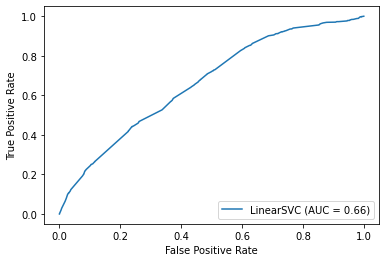

In [35]:
clf = svm.LinearSVC(random_state=0)
clf.fit(X_train, y_train)

metrics.plot_roc_curve(clf, X_test, y_test)  # doctest: +SKIP
plt.title('ROC Curve for Naive SVM Classifier')
plt.show()                                   # doctest: +SKIP

NameError: name 'plt' is not defined

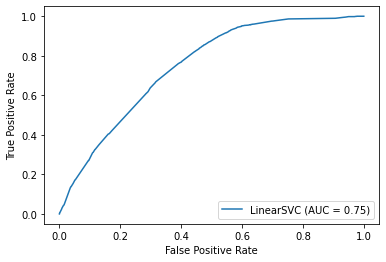

In [36]:
metrics.plot_roc_curve(clf, X_train, y_train)  # doctest: +SKIP
plt.title('ROC Curve for Naive SVM Classifier')
plt.show()  

In [ ]:
print(clf.dual_coef_[0])

In [ ]:
#note, runs orders of magnitude faster than multiclass SVC
clf1 = svm.LinearSVC(random_state=0)
clf1.fit(X_train, y_train)

metrics.plot_roc_curve(clf1, X_test, y_test)  # doctest: +SKIP
plt.title('ROC Curve for Naive SVM Classifier')
plt.show()  

In [ ]:
clf1.coef_.size #matches the number of features currently

In [ ]:
clf1.coef_

In [ ]:
coeffs = clf1.coef_[0]
coeffs = abs(coeffs)
coeffSorted = coeffs
coeffSorted.sort()
print(coeffSorted)

In [ ]:
i = 0;
for count in range(len(features)):
    j = len(features[count])
    sumWeight = sum(coeffs[i:i+j])
    i = i+1
    print('Total weight of %s is %.4f' %(featureNames[count], sumWeight))
    if(abs(coeffs[i]) == coeffSorted[-1]):
        print('Max value is %f with coefficient index %d' %(coeffs[i], i))
        
    #max value is 0.42209266 with coefficient index 17 corresponding to NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER
        

### Next iteration of GLM is to explore the presence of procedural events. 
#### All patients start with a 0 vector, with each element corresponding to whether or not a procedure was performed. Once we see a procedure performed, we sum the one hot encoding to the vector to get a count for each patient of what procedures were performed.

In [23]:
PROCEDURES = pd.read_csv('procedureEventsProcessed.csv')


In [24]:
procedures_dict = {}

unique_procedures = set()

for index, value in PROCEDURES['itemid'].items():
    if(value!='itemid'):
       unique_procedures.add(value)

val = 0
for key in unique_procedures:
    if(key!='nan'):
        procedures_dict[key] = val
        val = val+1
    
for key, value in procedures_dict.items():
    print(key, ' : ', value)

nan  :  0
225459  :  1
224263  :  2
225460  :  3
224276  :  4
225444  :  5
225451  :  6
224385  :  7
228125  :  8
225966  :  9
225794  :  10
224267  :  11
225439  :  12
225789  :  13
225466  :  14
224269  :  15
226476  :  16
224566  :  17
221217  :  18
225449  :  19
225805  :  20
225434  :  21
228129  :  22
221214  :  23
225450  :  24
225752  :  25
225427  :  26
225821  :  27
227194  :  28
225446  :  29
225792  :  30
226236  :  31
225479  :  32
227719  :  33
221255  :  34
225315  :  35
227712  :  36
221216  :  37
225454  :  38
224560  :  39
225433  :  40
225445  :  41
224273  :  42
225457  :  43
225817  :  44
225448  :  45
225469  :  46
225465  :  47
225462  :  48
225204  :  49
225470  :  50
226124  :  51
225430  :  52
225814  :  53
228128  :  54
225436  :  55
228127  :  56
225429  :  57
225399  :  58
225437  :  59
225802  :  60
225202  :  61
224270  :  62
225443  :  63
224264  :  64
221223  :  65
225464  :  66
225400  :  67
224272  :  68
225205  :  69
225816  :  70
224274  :  71
22540

In [25]:
procedures_oneHot = toOneHot(np.array(list(procedures_dict.values())))
for key,value in procedures_dict.items():
    procedures_dict[key] = procedures_oneHot[value]

print(procedures_dict)

{nan: array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), '225459': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), '224263': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 

In [26]:
X = pd.DataFrame([[-1,-1,-1]])
Y = pd.DataFrame([[0]])
#count = 0
for i in unique_patient_ids: #subject ids are strings
    curRow = PATIENTS[PATIENTS['SUBJECT_ID'] == i]
    curGender = curRow['GENDER'].iloc[0]
    if(curGender == 'M'):
        curGender = 0
    else:
        curGender = 1 #i.e. Female 1 Male 0
    
    curRow = ADMISSIONS[ADMISSIONS['SUBJECT_ID'] == i]
    curEthnicity = list(ethnicity_dict[curRow['ETHNICITY'].iloc[0]])
    curMarriageStatus = list(maritalStatus_dict[curRow['MARITAL_STATUS'].iloc[0]])
    curAdmissionType = list(admissionType_dict[curRow['ADMISSION_TYPE'].iloc[0]])
    curAdmissionLocation = list(admissionLocation_dict[curRow['ADMISSION_LOCATION'].iloc[0]])
    curDeathStatus = curRow['HOSPITAL_EXPIRE_FLAG'].iloc[0]
    
    curProcedures = np.zeros((1, len(procedures_dict['225439']))) #start off as 0 vector
    allProcedureIDs = PROCEDURES[PROCEDURES['SUBJECT_ID'] == i]['itemid']
    for procedureID in allProcedureIDs: #loop through all procedures and add each one hot encoding
        curProcedures = np.add(curProcedures, procedures_dict[procedureID])
    
    
    
    
    #update curValues to integers based on pre-processed dictionaries
    Xrow_i = []
    for val in curEthnicity:
        Xrow_i.append(val)
        
    for val in curMarriageStatus:
        Xrow_i.append(val)
        
    for val in curAdmissionType:
        Xrow_i.append(val)
        
    for val in curAdmissionLocation:
        Xrow_i.append(val)
        
    for val in curProcedures[0]:
        Xrow_i.append(val)

    Xrow_i = pd.Series(Xrow_i)
    
    
    Xrow_i_df = pd.DataFrame([Xrow_i])
    
    Yrow_i = pd.Series([curDeathStatus])
    Yrow_i_df = pd.DataFrame([Yrow_i])
    
    X = pd.concat([X, Xrow_i_df], ignore_index=True)
    Y = pd.concat([Y, Yrow_i_df], ignore_index=True)
    #count = count + 1

In [ ]:
PROCEDURES[PROCEDURES['SUBJECT_ID'] == '1860']

#### I include the example above because it demonstrates an issue that will have to be solved in the future: how to treat patients who have multiple visits to the ICU. For now, I lump together all stays.

In [27]:
X = X[1:] #first row invalid by construction
Y = Y[1:]
X

,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,144
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
y = Y
y_train = Y[:3*int(46520/4)].values.ravel()
y_test = Y[3*int(46520/4)+1:].values.ravel()

X_train = X[:3*int(46520/4)]
X_test = X.iloc[3*int(46520/4) + 1:,:]

NameError: name 'plt' is not defined

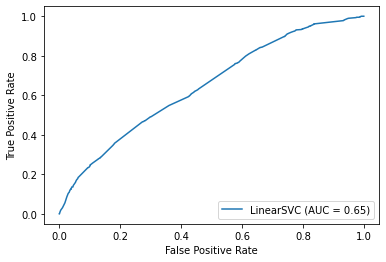

In [29]:
clf2 = svm.LinearSVC(random_state=0)
clf2.fit(X_train, y_train)

metrics.plot_roc_curve(clf2, X_test, y_test)  # doctest: +SKIP
plt.title('ROC Curve for SVM Classifier')
plt.show()  

NameError: name 'plt' is not defined

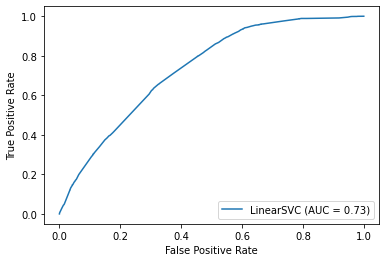

In [30]:
metrics.plot_roc_curve(clf2, X_train, y_train)  # doctest: +SKIP
plt.title('ROC Curve for SVM Classifier')
plt.show()  

In [ ]:
from sklearn.model_selection import cross_val_score
clf3 = svm.LinearSVC(random_state=0)


In [ ]:
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
clf.fit(X_train, y_train)

metrics.plot_roc_curve(clf, X_test, y_test)  # doctest: +SKIP
plot.title('ROC Curve for SVM Classifier')
plot.show()  

In [39]:
coeffs = clf2.coef_[0]
coeffs = abs(coeffs)
print(coeffs)
coeffSorted = coeffs
coeffSorted.sort()
print(coeffSorted)

[0.12136259 0.17977782 0.04356573 0.05341078 0.19836209 0.058383
 0.13825991 0.18799779 0.06184193 0.15714854 0.13937272 0.27349114
 0.1149961  0.16179888 0.21223308 0.05798161 0.19582793 0.34734901
 0.13129852 0.20288003 0.13483538 0.13483261 0.19164326 0.01984974
 0.072785   0.27508897 0.07757752 0.08509401 0.18749562 0.2360388
 0.10384066 0.07130479 0.07827158 0.06167086 0.08281042 0.01516783
 0.1150472  0.16180222 0.14158452 0.00485437 0.07566022 0.11843905
 0.24969496 0.00529461 0.08504468 0.00636692 0.13611181 0.13558809
 0.11472538 0.0482958  0.01740463 0.15580425 0.39288273 0.15758121
 0.08091621 0.18258127 0.124549   0.         0.15551922 0.16810047
 0.05866344 0.11896588 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.  

In [ ]:
featureNames.append('Procedure Events')
features.append(procedures_dict)

In [ ]:
i = 0;
for count in range(len(features)):
    j = len(features[count])
    sumWeight = sum(coeffs[i:i+j])
    i = i+1
    print('Total weight of %s is %.4f' %(featureNames[count], sumWeight))
    if(abs(coeffs[i]) == coeffSorted[-1]):
        print('Max value is %f with coefficient index %d' %(coeffs[i], i))

In [1]:
#meet with kirby to fix dataframe building
#seperate notebooks into easier to read
#bucketing of variables based on count - report count to PIs
#think about randomizing patients (since patient ID could be based on time)
#look at distribution of ages in test and training set (i.e. class balance between test/train)



#static, aperiodic, vital signs. have a team extract each set of variables -> integration -> feed into models. 

#use one-drive and github